<a href="https://colab.research.google.com/github/ArashDehghanyan/ml-practicres/blob/main/Load_and_preprocess_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import os
import PIL 
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds

In [2]:
print(tf.__version__)
print(tf.version.VERSION)

2.8.0
2.8.0


##Download Dataset

In [3]:
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

data_dir = keras.utils.get_file(
    fname='flower_photos', origin=dataset_url, untar=True
)

data_dir = pathlib.Path(data_dir)

228827136/228813984 [==============================] - 3s 0us/step


In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


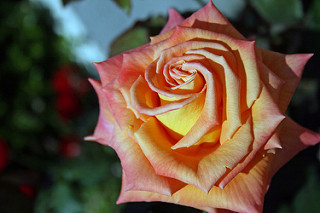

In [9]:
roses = list(data_dir.glob('roses/*'))
Image.open(str(roses[2]))

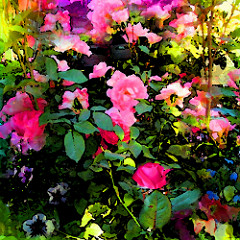

In [7]:
Image.open(str(roses[4]))

In [10]:
print(data_dir)

/root/.keras/datasets/flower_photos


##Load data using Keras utility

In [12]:
# Define some parameters for the loader
batch_size = 32
img_height = 180
img_width = 180

train_dataset = keras.utils.image_dataset_from_directory(
    data_dir, validation_split=0.2, subset='training', seed=123, batch_size=batch_size, image_size=(img_height, img_width)
)

validation_dataset = keras.utils.image_dataset_from_directory(
    data_dir, validation_split=0.2, subset="validation", seed=123, image_size=(img_height, img_width), batch_size=batch_size
)

class_names = train_dataset.class_names
print(class_names)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.
['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


##Visualize data

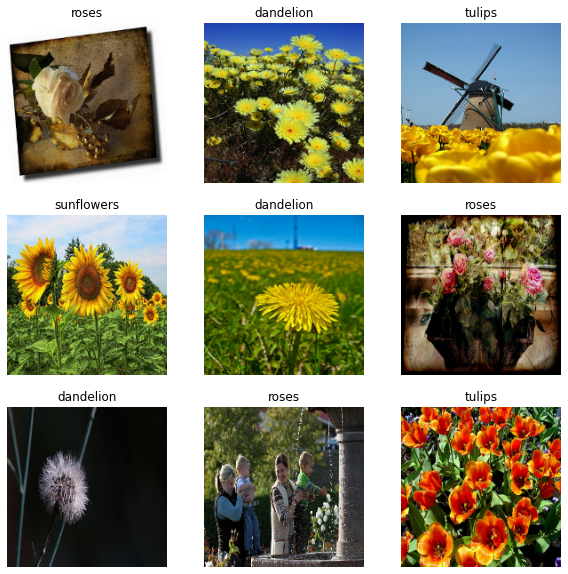

In [13]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [14]:
for image_batch, label_batch in train_dataset:
    print(image_batch.shape)
    print(label_batch.shape)
    break

(32, 180, 180, 3)
(32,)
